
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PEPACS module
from pepacs.agents.pepacs import PEPACS, Configuration

from pepacs.agents.pepacs.utils.Plotting_wrapper import \
    parse_metrics_to_df, \
    plot_performance

from pepacs.metrics import \
    _maze_metrics, \
    _how_many_peps_match_non_aliased_states, \
    _mean_reliable_classifier_specificity, \
    _when_full_knowledge_is_achieved, \
    _state_of_population

# Load environments
import gym
import my_mazes

# Agent - PEPACS

## Common parameters

In [2]:
CLASSIFIER_LENGTH = 8
NUMBER_OF_POSSIBLE_ACTIONS = 8

MAZE = "Woods100-v0"

NUMBER_OF_EXPLORE_TRIALS = 500
METRICS_TRIAL_FREQUENCY_EXPLORE = 1
BETA_ALP = 0.05
BETA_RL = 0.05
BETA_PEP = 0.01
EPSILON = 0.8

DO_GA = True
ENABLE_PEP = True

SLIPPERY_PROB = 0.

## Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Set up probability to do a random action
maze.env.set_prob_slippery(SLIPPERY_PROB)
# Reset it, by putting an agent into random position
maze.reset()
# Render the state in ASCII
maze.render('aliasing_human')


■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ ■ A $ □ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■


## Training of PEPACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=METRICS_TRIAL_FREQUENCY_EXPLORE,
    do_pep=ENABLE_PEP,
    do_ga=DO_GA,
    beta_alp=BETA_ALP,
    beta_rl=BETA_RL,
    beta_pep=BETA_PEP,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8
)

agent_explore = PEPACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 2.54 s, sys: 21.2 ms, total: 2.56 s
Wall time: 2.62 s


### Performance

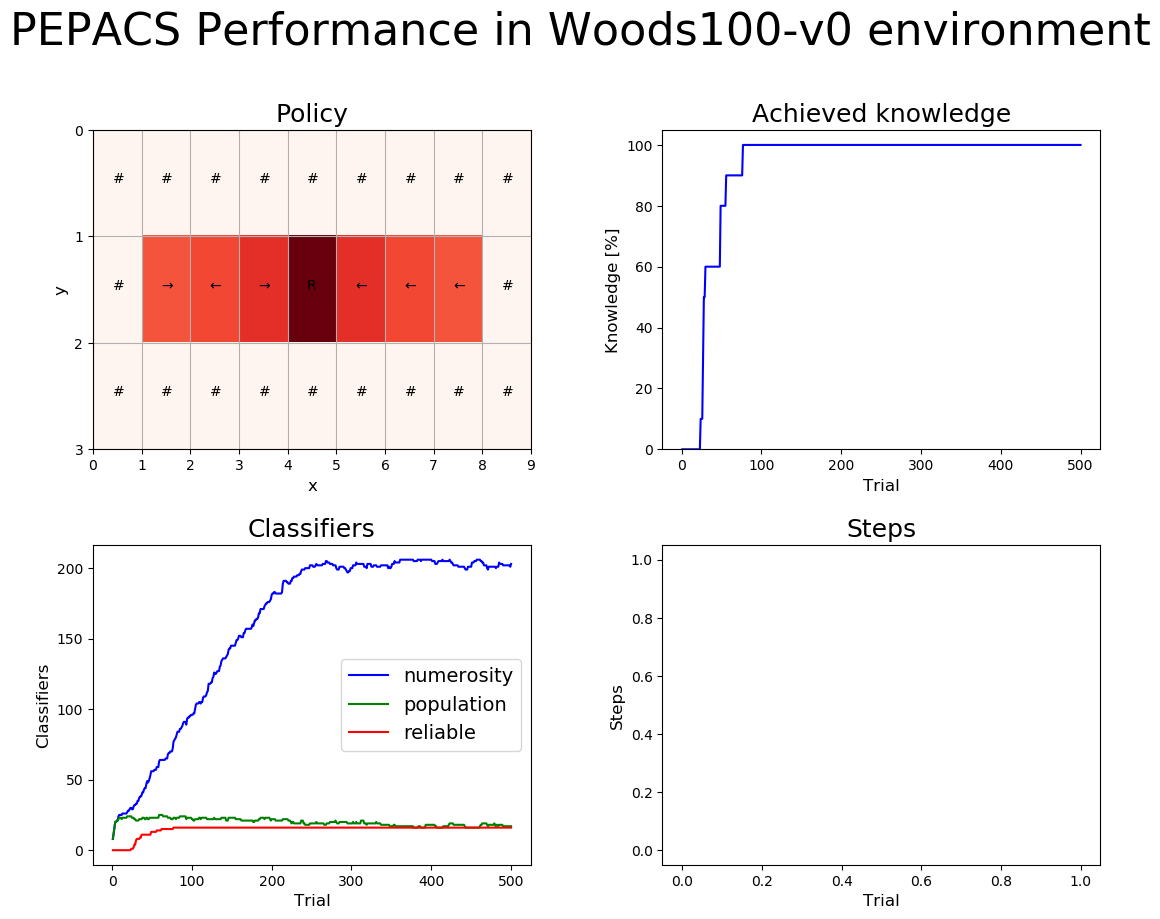

In [5]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, None, None)
plot_performance(agent_explore, maze, metrics_df, cfg_explore, MAZE, metrics_trial_frequency_explore, None)

In [6]:
print(_maze_metrics(population_explore, maze))

first_trial, stable_trial = _when_full_knowledge_is_achieved(metrics_explore)

print("Full knowledge was achieved at trials ", first_trial, " and was stable at ", stable_trial)

print("There are ", _how_many_peps_match_non_aliased_states(population_explore, maze),
      " enhanced classifer(s) that match a non-aliased states.")

print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))

print(_state_of_population(metrics_explore, first_trial))

{'knowledge': 100.0, 'population': 17, 'numerosity': 203, 'reliable': 16}
Full knowledge was achieved at trials  77  and was stable at  77
There are  0  enhanced classifer(s) that match a non-aliased states.
Mean reliable population specifity is  0.09375
{'trial': 77, 'steps_in_trial': 95, 'reward': 1000, 'knowledge': 100.0, 'population': 23, 'numerosity': 77, 'reliable': 16}


In [7]:
population_explore.sort(key=lambda cl: -cl.fitness)
population_explore_to_display = [(cl.condition, cl.action, cl.effect, cl.exp) for cl in population_explore
    if cl.is_reliable() and cl.is_enhanced()]
print(len(population_explore_to_display))
for cl in population_explore_to_display:
    print(cl)
    print("\n")

2
(##0###0#, 6, ######{9:52.51%, 1:47.49%}#, 686)


(##0###0#, 2, ##{1:50.47%, 9:49.53%}#####, 695)


